In [0]:
# https://colab.research.google.com/drive/1EPZn-Hkm-l_FPmQNXn3G6HpCpJWUj7oWhttps://colab.research.google.com/drive/1EPZn-Hkm-l_FPmQNXn3G6HpCpJWUj7oW%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

import random
import time
from collections import defaultdict
from collections import deque
from copy import deepcopy 


def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

In [0]:
# Import environments
import gym
cartpole_env = gym.envs.make("CartPole-v0")
mountaincar_env = gym.envs.make("MountainCar-v0")

In [0]:
# Set seeds (this is a reproducibility lab after all)
def set_seeds(seed):
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)
  cartpole_env.seed(seed)

In [0]:
# Q-net
class QNetwork(nn.Module):
    
    def __init__(self, state_space, action_space, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(state_space, num_hidden)
        self.l2 = nn.Linear(num_hidden, action_space)

    def forward(self, x):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        return x

In [0]:
# Create experience replay memory
class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            self.memory.pop(0)

    def sample(self, batch_size):
      return ([], random.sample(self.memory, batch_size), [])

    def __len__(self):
        return len(self.memory)

In [0]:
# Create prioritized experience replay memory
class PrioritizedReplayMemory:
    
    def __init__(self, capacity, epsilon = 0.001, prioritization = 1):
        self.capacity = capacity
        self.memory = []
        self.priorities = []
        self.max_priority = 1
        self.epsilon = epsilon
        self.prioritization = prioritization

    def push(self, transition):
        self.memory.append(transition)
        self.priorities.append(self.max_priority)
        if len(self.memory) > self.capacity:
            self.memory.pop(0)
            self.priorities.pop(0)

    def sample(self, batch_size):
      # Proportional sampling based on priorities (rank based could be implemented as well)
      # Note: I think we also have to use importance sampling
      priorities = np.asarray(self.priorities)
      priorities = priorities + self.epsilon # This is to make everything have non-zero probability
      priorities = priorities ** self.prioritization # This controls how strongly we prioritize transitions with higher errors
      priorities = priorities/priorities.sum()
      sample = np.random.choice(list(range(len(self.memory))), batch_size, False, priorities)
      return (sample, np.asarray(self.memory)[sample], priorities)

    def __len__(self):
        return len(self.memory)

In [0]:
# Epsilon annealing
def get_epsilon(it):
    return max(0.05, 1 - it * 0.95 /1000)

In [0]:
# Beta annealing
def get_beta(episode):
    return 0.4 + (episode+1)/num_episodes*0.6

In [0]:
# Action selection
def select_action(model, state, epsilon):
    with torch.no_grad():
        Q_values = model(torch.Tensor(state))
        if random.random() > epsilon:
            return Q_values.argmax().item()
        else:
            v = random.randint(0, Q_values.shape[0]-1)
            return v

## HER


In [0]:
class HER:
    def __init__(self):
        self.buffer = deque()
        
    def reset(self):
        self.buffer = deque()
        
    def push(self,item):
        self.buffer.append(item)
        
    def backward(self):
        transitions = len(self.buffer)
        # the tuple is S, A, R', S', done
        # the state has 3 dims because it is concatenated with goal
        # in the beggining the goal is the last state in our baffer.

        last_tuple = -1
        state_goal = 0
        reward = 2
        next_state_goal = 3
        done = 4
        prev_goal = 2
        goal = 2
        state = 1

        # print(self.buffer[last_tuple][next_state_goal])
        # final_goal = self.buffer[last_tuple][next_state_goal][state]

        #print(self.buffer[last_tuple][next_state_goal])
        final_goal = self.buffer[last_tuple][next_state_goal][0]
        #print(final_goal)
        for i in range(transitions):
            prev_tuple = -1-i
            
            #print(self.buffer[prev_tuple][next_state_goal])
            # we iterate and set the goal to S and S' of the previous tuple.
            to_list = list(self.buffer[prev_tuple])
            to_list[0] = np.append(self.buffer[prev_tuple][state_goal], final_goal)
            to_list[3] = np.append(self.buffer[prev_tuple][next_state_goal], final_goal)
            to_list[2] = -1.0
            to_list[4] = False
            self.buffer[prev_tuple] = tuple(to_list)

            # self.buffer[prev_tuple][reward] = -1.0
            # self.buffer[prev_tuple][done] = False

            # if the next state S' is the final_goal we set the reward and the done.
            
            n_state = self.buffer[prev_tuple][next_state_goal]
            
            if n_state[0] == final_goal:
               to_list = list(self.buffer[prev_tuple])
               to_list[2] = 0.0
               to_list[4] = True
               self.buffer[prev_tuple] = tuple(to_list)

        return self.buffer

In [0]:
# Training code
def compute_q_val(model, state, action):
    return model(state).gather(1, action.unsqueeze(1)).squeeze()    
    
def compute_target(model, reward, next_state, done, discount_factor):
    # done is a boolean (vector) that indicates if next_state is terminal (episode is done)
    return reward + discount_factor * model(next_state).max(1)[0] * (1 - done.float())

def train(model, memory, optimizer, batch_size, discount_factor, beta):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    indexes, transitions, priorities = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    
    # compute the q value
    q_val = compute_q_val(model, state, action)
    
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_target(model, reward, next_state, done, discount_factor)
        
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target, reduce = False)
    
    # Update priorities
    if isinstance(memory, PrioritizedReplayMemory):
      errors = (target - q_val).abs()
      for i, idx in enumerate(indexes):
        error = errors[i].item()
        memory.priorities[idx] = error
      memory.max_priority = max(memory.priorities)
      
      # Multiply with importance sampling weights
      iml = 1/len(memory)
      for i, idx in enumerate(indexes):
        loss[i] *=  (iml * 1/priorities[idx])**beta
    
    
    loss = loss.mean() 
    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())
  
def run_episodes(train, memory, env, num_episodes, batch_size, discount_factor, learn_rate, printable=False):
 
  # Create Q-net
  num_hidden = 128
  goal = 1
  state_space = env.reset().size
  action_space = env.action_space.n
  model = QNetwork(state_space + goal, action_space, num_hidden)
  optimizer = optim.Adam(model.parameters(), learn_rate)
  her = HER()

  global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
  episode_durations = []  #
  for i in range(num_episodes):
      State = env.reset()
      Done = False
      steps = 0
      her.reset()
      while not Done:
          epsilon = get_epsilon(global_steps)
          beta = get_beta(i)

          m_State = deepcopy(State)
          m_State = np.append(m_State, 0.5)
         

          Action = select_action(model, m_State, epsilon)
          (State_, Reward, Done, _) = env.step(Action)

          m_Action = deepcopy(Action)
          m_Reward = deepcopy(Reward)
          m_Next_State = deepcopy(State_)
          m_Done = deepcopy(Done)

          m_Next_State = np.append(m_Next_State, 0.5)

          memory.push((m_State, m_Action, m_Reward, m_Next_State, m_Done))
          her.push((State, Action, Reward, State_, Done))

          train(model, memory, optimizer, batch_size, discount_factor, beta)
          State = State_
          steps += 1
          global_steps += 1
      
      # HER
      her_list = her.backward()
      for item in her_list:
          memory.push(item)

      episode_durations.append(steps)
      if printable:
          if i % 10 == 0:
            print(i)
  return episode_durations

In [0]:
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [0]:
# Hyperparameters
  num_episodes = 100
  batch_size = 64
  discount_factor = 0.9
  learn_rate = 1e-3
  

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


[18.4 15.4 19.2 22.4 22.4 22.6 22.9 22.1 21.3 22.9 22.9 25.3 21.7 20.5
 19.9 22.  23.4 25.7 26.1 26.1 25.5 22.8 23.2 20.3 20.7 18.4 16.7 13.9
 13.  11.9 11.9 11.6 10.9 10.9 11.3 11.3 11.2 11.4 22.6 23.4 26.1 28.6
 33.1 42.3 45.9 49.4 53.5 57.5 51.5 64.2 65.2 66.  65.  61.7 63.  64.3
 67.3 68.8 74.7 65.4 65.5 71.5 71.2 74.3 77.5 79.2 84.9 92.6 92.7 88.7
 84.6 89.5 89.6 84.3 89.6 87.1 78.  69.1 71.5 76.9 82.8 68.7 65.4 63.4
 53.  53.3 49.7 51.7 41.  39.  38.1]


Text(0.5, 1.0, 'Episode durations per episode')

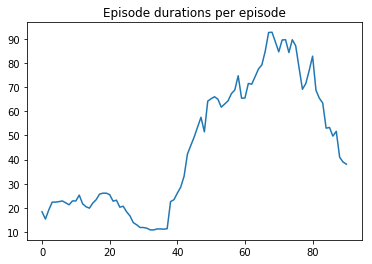

In [331]:
# Create memory
memory = ReplayMemory(10000)

# Set seeds
set_seeds(1)

# Run
episode_durations = run_episodes(train, memory, cartpole_env, num_episodes, batch_size, discount_factor, learn_rate)

# Plot
print(smooth(episode_durations, 10))
plt.plot(smooth(episode_durations, 10))
plt.title('Episode durations per episode')

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Text(0.5, 1.0, 'Episode durations per episode')

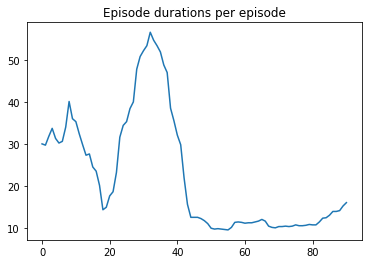

In [332]:

# Create memory
memory = PrioritizedReplayMemory(1000)

# Set seeds
set_seeds(1)

# Run
episode_durations = run_episodes(train, memory, cartpole_env, num_episodes, batch_size, discount_factor, learn_rate)

# Plot
plt.plot(smooth(episode_durations, 10))
plt.title('Episode durations per episode')

## Pipeline

In [0]:
def run_experiments(replay_func, environment, capacity, num_experiments, smoothing_factor, num_episodes, batch_size, discount_factor, learn_rate):
    nr_datapoints = num_episodes - smoothing_factor + 1
    experiments = np.zeros(nr_datapoints)
    
    for i in range(num_experiments):
        print('Experiment', i)
        memory = replay_func(capacity)
        set_seeds(1)
        episode_durations = run_episodes(train, memory, cartpole_env, num_episodes, batch_size, discount_factor, learn_rate)
        experiments = np.vstack((experiments, np.array(smooth(episode_durations, smoothing_factor))))

    # Delete initial zero entries    
    np.delete(experiments, 0, 0)

    # Plot
    means, stds = np.mean(experiments, axis=0), np.std(experiments, axis=0)
    plt.plot(means, color='blue')
    plt.fill_between(np.arange(nr_datapoints), means - stds, means + stds, alpha=0.5)
    plt.title('Average episode durations over {} experiments'.format(num_experiments))

Experiment 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Experiment 1
Experiment 2


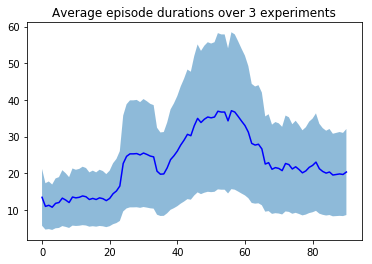

In [334]:
run_experiments(ReplayMemory, cartpole_env, capacity=10000, num_experiments=3, smoothing_factor=10, num_episodes=100, batch_size=64, discount_factor=0.8, learn_rate=0.001)

Experiment 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Experiment 1
Experiment 2


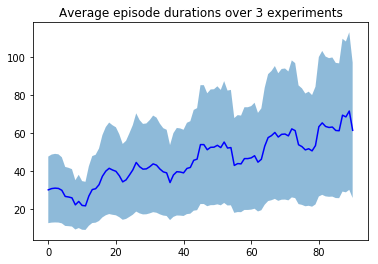

In [335]:
run_experiments(PrioritizedReplayMemory, cartpole_env, capacity=10000, num_experiments=3, smoothing_factor=10, num_episodes=100, batch_size=64, discount_factor=0.8, learn_rate=0.001)